In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
# check content of drive
!ls "/content/drive/My Drive/THESIS 2/Thesis Internal/Code"

 01_models_test_cases					   Pretagging
 audio_augmentation					   resnet_testcases.gsheet
 Axl_Test						   Russel_Test
 binary_audio_cleaned_cropped				   test_binary_vandanaModel.ipynb
'Copy of test_InceptionV3_model1 [ITO NA YUN AXL].ipynb'   test_customModel1.ipynb
 Dataset						   test_inceptionV3_model1.ipynb
 dev_split_mfcc_augmented_Depression_AVEC2017_2		   test_InceptionV3_model1_V2.ipynb
 Eli_Test						   test_split_audio_Depression_AVEC2017_2
 inceptionV3_model1_testcases.gsheet			   test_split_mfcc_Depression_AVEC2017_2
 level_4						   train_split_audio_Depression_AVEC2017_2
 model							   train_split_mfcc_Depression_AVEC2017_2
'old datasets used'


In [17]:
%matplotlib inline
from IPython import display
import os
import math
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import *
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

np.random.seed(42)
tf.random.set_seed(42)

## Importing and Splitting the dataset

In [18]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

data_dir = "/content/drive/My Drive/THESIS 2/Thesis Internal/Code/train_split_mfcc_Depression_AVEC2017_2" #change_path
test_data_dir = "/content/drive/My Drive/THESIS 2/Thesis Internal/Code/test_split_mfcc_Depression_AVEC2017_2" #change_path

aug_data_dir = "/content/drive/My Drive/THESIS 2/Thesis Internal/Code/dev_split_mfcc_augmented_Depression_AVEC2017_2" #change_path

def image_generator(height, width):
    datagen = ImageDataGenerator(
        rescale=1./255.,
        validation_split=0.1, #to change split
    )

    test_datagen = ImageDataGenerator(
        rescale=1./255.
    )

    aug_datagen = ImageDataGenerator(
        rescale=1./255.
    )

    # Modify the flow_from_directory method to handle 5 classes
    train_ds = datagen.flow_from_directory(
        data_dir,
        batch_size=batch_size,
        subset="training",
        shuffle=True,
        class_mode='categorical', #changed
        target_size=(height, width),
        classes={'level_0': 0, 'level_1': 1, 'level_2': 2, 'level_3': 3, 'level_4': 4}
    )

    val_ds = datagen.flow_from_directory(
        data_dir,
        subset="validation",
        class_mode='categorical', #changed
        target_size=(height, width),
        batch_size=batch_size,
        classes={'level_0': 0, 'level_1': 1, 'level_2': 2, 'level_3': 3, 'level_4': 4}
    )

    test_ds = test_datagen.flow_from_directory(
        test_data_dir,
        batch_size=batch_size,
        shuffle=True,
        class_mode='categorical', #changed
        target_size=(height, width),
        classes={'level_0': 0, 'level_1': 1, 'level_2': 2, 'level_3': 3, 'level_4': 4}
    )

    aug_train_ds = aug_datagen.flow_from_directory(
        aug_data_dir,
        batch_size=batch_size,
        shuffle=True,
        class_mode='categorical', #changed
        target_size=(height, width),
        classes={'level_0': 0, 'level_1': 1, 'level_2': 2, 'level_3': 3, 'level_4': 4}
    )

    return train_ds, val_ds, test_ds, aug_train_ds

batch_size = 32  # add batch_size here or elsewhere in your code
height, width = 400, 1000  #change
train_ds, val_ds, test_ds, aug_train_ds = image_generator(height, width)

# Change your print statement to reflect the 5 classes
total_image = np.concatenate([train_ds.labels, val_ds.labels])
class_counts = {}
for i in range(5):
    class_name = f'level_{i}'
    class_counts[class_name] = len(np.where(total_image==i)[0])

print('\n\n', class_counts)


Found 130 images belonging to 5 classes.
Found 12 images belonging to 5 classes.
Found 47 images belonging to 5 classes.
Found 567 images belonging to 5 classes.


 {'level_0': 64, 'level_1': 35, 'level_2': 25, 'level_3': 13, 'level_4': 5}


## Visualizing the dataset

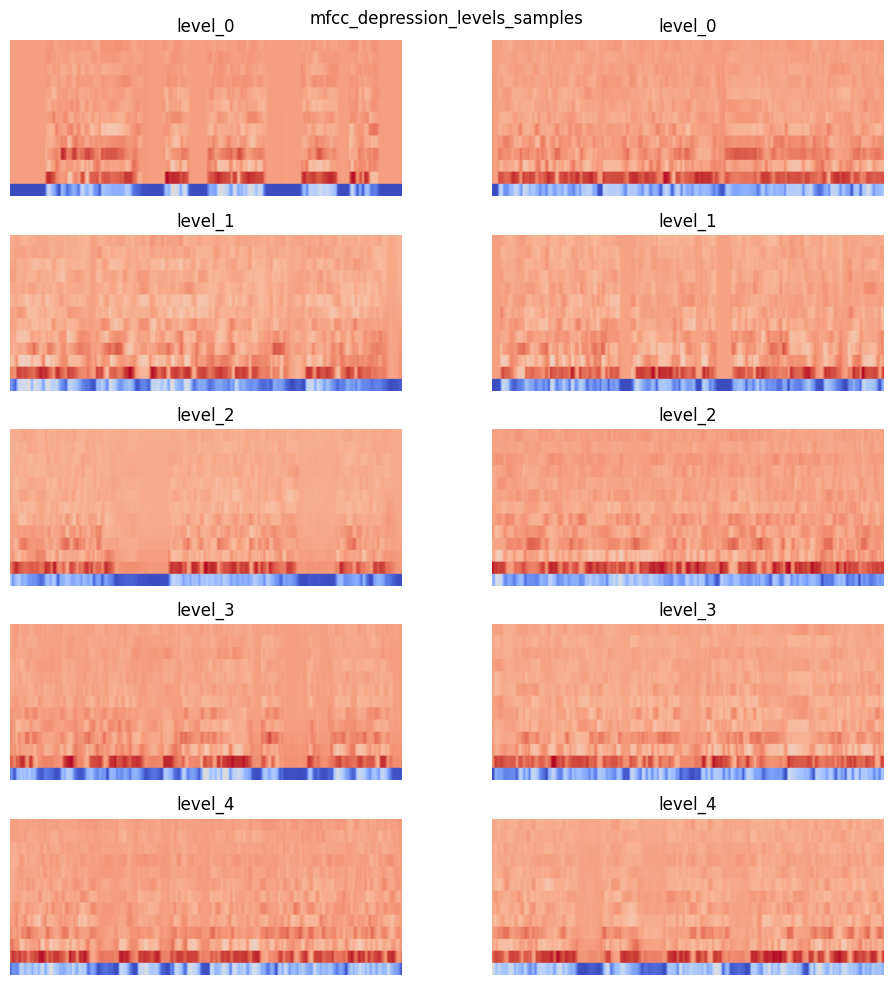

In [19]:
import matplotlib.pyplot as plt

# single_image_height = 4  # inches
# single_image_width = single_image_height * 2.5  # inches

# fig_width = 2 * single_image_width  # since there are 2 columns
# fig_height = 5 * single_image_height  # since there are 5 rows

# fig, ax = plt.subplots(5, 2, figsize=(fig_width, fig_height))
fig, ax = plt.subplots(5, 2, figsize=(10, 10))  # 5 levels x 2 samples
fig.suptitle("mfcc_depression_levels_samples")

class_dict = {v: k for k, v in train_ds.class_indices.items()}
samples_needed = {k: 2 for k in range(5)}
collected_samples = {k: [] for k in range(5)}

while any(v > 0 for v in samples_needed.values()):
    images, labels = train_ds.next()
    for image, label in zip(images, labels):
        label_index = np.argmax(label)
        if samples_needed[label_index] > 0:
            collected_samples[label_index].append(image)
            samples_needed[label_index] -= 1

# Plot the collected samples
for label_index, images_list in collected_samples.items():
    for i, image in enumerate(images_list):
        ax[label_index, i].imshow(image)
        ax[label_index, i].set_title(f'{class_dict[label_index]}')
        ax[label_index, i].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Adjust the top space for the main title
plt.show()


## Visualizing the augmented dataset

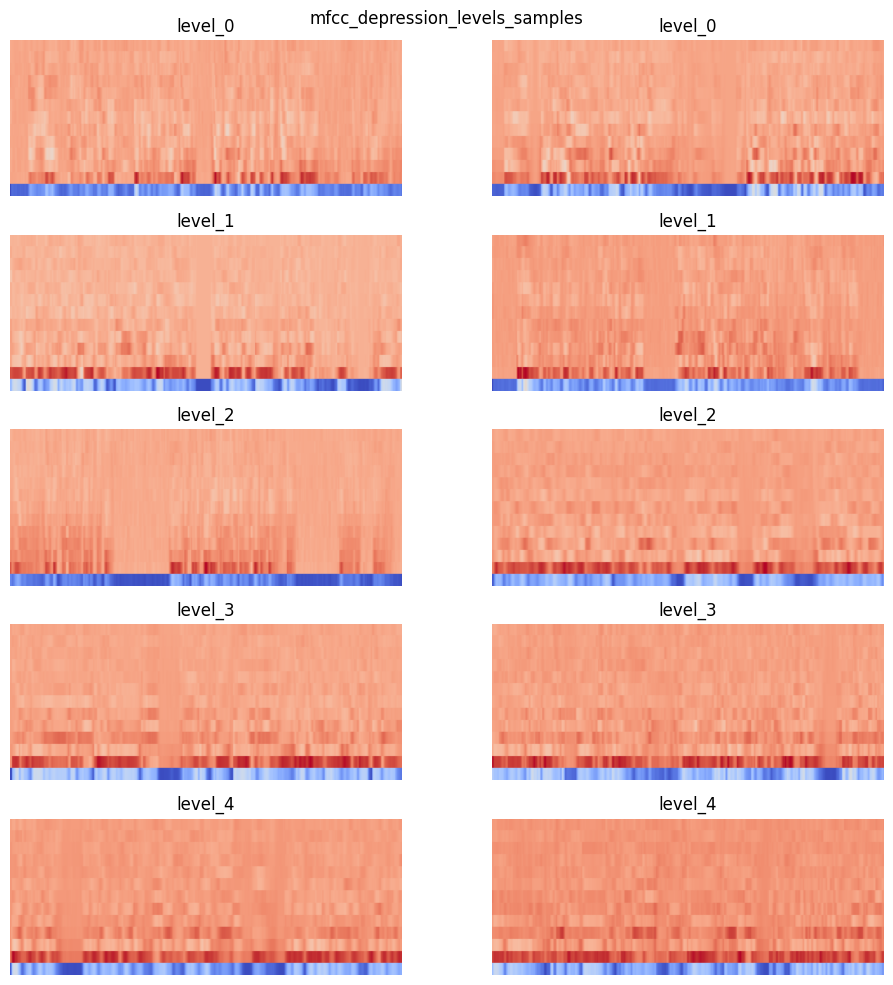

In [20]:
import matplotlib.pyplot as plt

# single_image_height = 4  # inches
# single_image_width = single_image_height * 2.5  # inches

# fig_width = 2 * single_image_width  # since there are 2 columns
# fig_height = 5 * single_image_height  # since there are 5 rows

# fig, ax = plt.subplots(5, 2, figsize=(fig_width, fig_height))
fig, ax = plt.subplots(5, 2, figsize=(10, 10))  # 5 levels x 2 samples
fig.suptitle("mfcc_depression_levels_samples")

class_dict = {v: k for k, v in aug_train_ds.class_indices.items()}
samples_needed = {k: 2 for k in range(5)}
collected_samples = {k: [] for k in range(5)}

while any(v > 0 for v in samples_needed.values()):
    images, labels = aug_train_ds.next()
    for image, label in zip(images, labels):
        label_index = np.argmax(label)
        if samples_needed[label_index] > 0:
            collected_samples[label_index].append(image)
            samples_needed[label_index] -= 1

# Plot the collected samples
for label_index, images_list in collected_samples.items():
    for i, image in enumerate(images_list):
        ax[label_index, i].imshow(image)
        ax[label_index, i].set_title(f'{class_dict[label_index]}')
        ax[label_index, i].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Adjust the top space for the main title
plt.show()


# Applying Class Weights to address Imbalanced dataset

In [21]:
#adding class weights
from sklearn.utils.class_weight import compute_class_weight

# Assuming train_ds.classes provides the class indices of the training data
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_ds.classes),
    y=train_ds.classes
)

# Turn class_weights into a dictionary to use it with Keras
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}


## To keep track of Time duration during training

In [22]:
import time

class TimingCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(TimingCallback, self).__init__()
        self.epoch_times = []

    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        elapsed_time = time.time() - self.start_time
        self.epoch_times.append(elapsed_time)
        print(f"Epoch {epoch + 1}: {elapsed_time:.2f} seconds")

    def on_train_begin(self, logs=None):
        self.total_time = time.time()

    def on_train_end(self, logs=None):
        total_time_elapsed = time.time() - self.total_time
        avg_time_per_epoch = sum(self.epoch_times) / len(self.epoch_times)
        print(f"Total training time: {total_time_elapsed:.2f} seconds")
        print(f"Average time per epoch: {avg_time_per_epoch:.2f} seconds")


## Initial ResNet50 Model


In [23]:
import tensorflow as tf

tf.keras.backend.clear_session()

# Assuming height and width are defined elsewhere in your code
input_shape = (height, width, 3)

# Using ResNet50 as the base model
base_model_resnet50 = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)
base_model_resnet50.trainable = False

model_resnet50 = tf.keras.Sequential()
model_resnet50.add(base_model_resnet50)
model_resnet50.add(tf.keras.layers.GlobalAveragePooling2D())  # Using Global Average Pooling

model_resnet50.add(tf.keras.layers.Dropout(0.2))  # Dropout layer

# Adjusted for 5 classes with softmax activation
model_resnet50.add(tf.keras.layers.Dense(5, activation='softmax'))

model_resnet50.compile(loss='categorical_crossentropy',
                       optimizer=tf.keras.optimizers.Adam(0.0001),  # Adam optimizer
                       metrics=['accuracy'])  # Using 'accuracy' instead of 'acc' for clarity

model_resnet50.summary()


94765736/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 13, 32, 2048)      23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                                 
Total params: 23597957 (90.02 MB)
Trainable params: 10245 (40.02 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [24]:
# Adjusting to monitor validation accuracy
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/My Drive/THESIS 2/Thesis Internal/Code/model/resnet50_initial.h5', monitor='val_loss', verbose=1, mode='min', save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", restore_best_weights=True, patience=5)
time_callback = TimingCallback()
callbacks_list = [checkpoint, early, time_callback]
# callbacks_list = [checkpoint]

history = model_resnet50.fit(
        train_ds,
        validation_data=val_ds,
        epochs=50,
        shuffle=True,
        verbose=True,
        callbacks=callbacks_list,
        class_weight=class_weight_dict  # Pass class weights here
)

Epoch 1/50
5/5 [==============================] - ETA: 0s - loss: 1.9946 - accuracy: 0.2000
Epoch 1: val_loss improved from inf to 1.73950, saving model to /content/drive/My Drive/THESIS 2/Thesis Internal/Code/model/resnet50_initial.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1: 83.37 seconds
5/5 [==============================] - 83s 14s/step - loss: 1.9946 - accuracy: 0.2000 - val_loss: 1.7395 - val_accuracy: 0.0833
Epoch 2/50
5/5 [==============================] - ETA: 0s - loss: 1.9748 - accuracy: 0.1231
Epoch 2: val_loss improved from 1.73950 to 1.66746, saving model to /content/drive/My Drive/THESIS 2/Thesis Internal/Code/model/resnet50_initial.h5
Epoch 2: 68.61 seconds
5/5 [==============================] - 69s 13s/step - loss: 1.9748 - accuracy: 0.1231 - val_loss: 1.6675 - val_accuracy: 0.1667
Epoch 3/50
5/5 [==============================] - ETA: 0s - loss: 1.8771 - accuracy: 0.1462
Epoch 3: val_loss improved from 1.66746 to 1.62399, saving model to /content/drive/My Drive/THESIS 2/Thesis Internal/Code/model/resnet50_initial.h5
Epoch 3: 63.73 seconds
5/5 [==============================] - 64s 12s/step - loss: 1.8771 - accuracy: 0.1462 - val_loss: 1.6240 - val_accuracy: 0.1667
Epoch 4/50
5/5 [==============================] - ETA: 0s - loss: 1

## Evaluation of *Initial Model*

In [25]:
train_result = model_resnet50.evaluate(train_ds)
val_result = model_resnet50.evaluate(val_ds)
test_result = model_resnet50.evaluate(test_ds)

no_augmented_df = pd.DataFrame(zip(train_result,val_result,test_result),columns=['Train','Val','Test'],index=['Loss','Acc'])
no_augmented_df

2/2 [==============================] - 20s 6s/step - loss: 1.5736 - accuracy: 0.2340


,Train,Val,Test
Loss,1.574674,1.5617,1.573581
Acc,0.246154,0.2500,0.234043


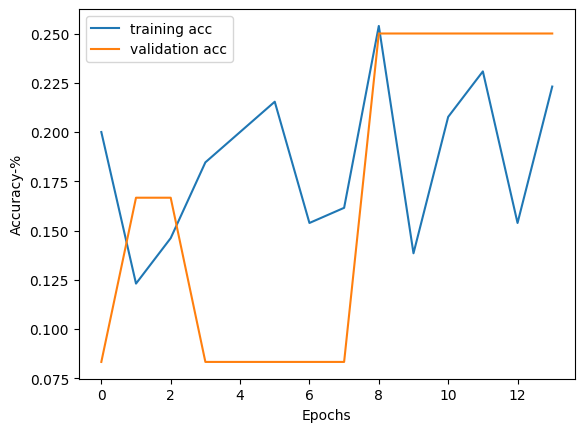

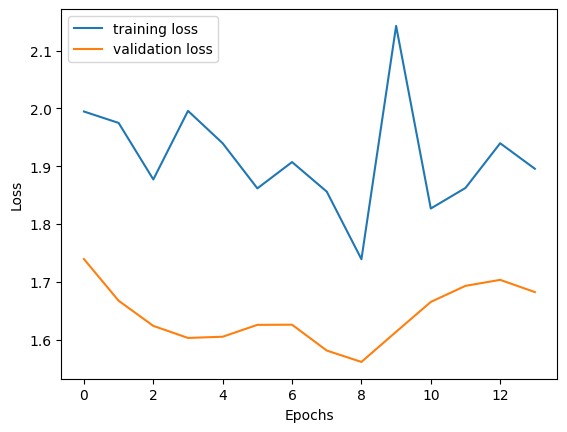

In [26]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy-%')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plot_learning_curve(history)

In [27]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1. Predict the classes and probabilities for the test dataset
test_pred_prob = model_resnet50.predict(test_ds)
test_pred = np.argmax(test_pred_prob, axis=1)
test_true = test_ds.labels

# Determine the number of classes in the test dataset
n_classes = len(np.unique(test_true))

# 2. Compute the metrics for the test dataset

# Test metrics
test_precision = precision_score(test_true, test_pred, average='weighted', zero_division=1)
test_recall = recall_score(test_true, test_pred, average='weighted')
test_f1 = f1_score(test_true, test_pred, average='weighted')
test_conf_matrix = confusion_matrix(test_true, test_pred, labels=list(range(n_classes)))
test_true_onehot = np.eye(n_classes)[test_true]
test_roc_auc = roc_auc_score(test_true_onehot, test_pred_prob, multi_class='ovr')

# Create a dataframe to display the results for the test set
test_metrics_df = pd.DataFrame({
    'Test': [test_precision, test_recall, test_f1, test_roc_auc]
}, index=['Precision', 'Recall', 'F1 Score', 'AUC'])

print("Test Metrics DataFrame:")
print(test_metrics_df)

print("\nTest Confusion Matrix:")
print(test_conf_matrix)


2/2 [==============================] - 22s 6s/step
Test Metrics DataFrame:
               Test
Precision  0.820733
Recall     0.234043
F1 Score   0.088775
AUC        0.618323

Test Confusion Matrix:
[[ 0 22  0  0  0]
 [ 0 11  0  0  0]
 [ 0  5  0  0  0]
 [ 0  7  0  0  0]
 [ 0  2  0  0  0]]


In [28]:
# Assuming test_conf_matrix is already computed as shown in your code
n_classes = len(np.unique(test_true))  # Number of classes

# Initialize arrays to store TP, FP, FN, TN for each class
TP = np.zeros(n_classes)
FP = np.zeros(n_classes)
FN = np.zeros(n_classes)
TN = np.zeros(n_classes)

# Calculate TP, FP, FN, TN for each class
for i in range(n_classes):
    TP[i] = test_conf_matrix[i, i]
    FP[i] = test_conf_matrix[:, i].sum() - TP[i]
    FN[i] = test_conf_matrix[i, :].sum() - TP[i]
    TN[i] = test_conf_matrix.sum() - (FP[i] + FN[i] + TP[i])

print("Confusion Matrix Metrics by Class:")
TP_list = TP.tolist()
TN_list = TN.tolist()
FP_list = FP.tolist()
FN_list = FN.tolist()

metrics_by_class = list(zip(TP_list, TN_list, FP_list, FN_list))

# Print the transposed lists
for i, class_metrics in enumerate(metrics_by_class):
    print(f"Class {i}: {class_metrics}")

Confusion Matrix Metrics by Class:
Class 0: (0.0, 25.0, 0.0, 22.0)
Class 1: (11.0, 0.0, 36.0, 0.0)
Class 2: (0.0, 42.0, 0.0, 5.0)
Class 3: (0.0, 40.0, 0.0, 7.0)
Class 4: (0.0, 45.0, 0.0, 2.0)


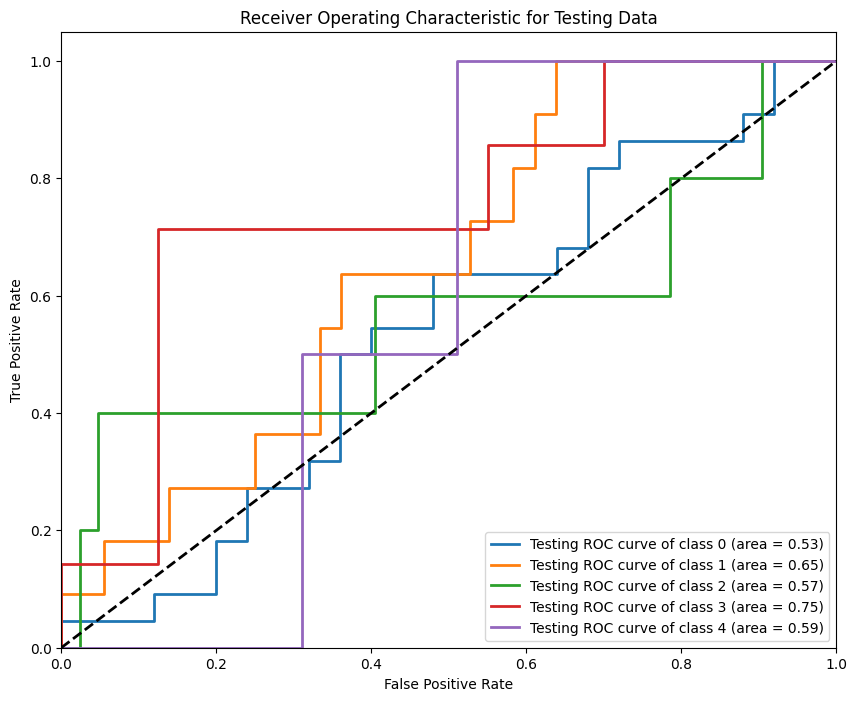

In [29]:
#Matrix Visualization
# Training AUC curve
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(test_true_onehot[:, i], test_pred_prob[:, i])
    plt.plot(fpr, tpr, lw=2, label=f'Testing ROC curve of class {i} (area = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Testing Data')
plt.legend(loc="lower right")
plt.show()

**TEST CASES INSERTION**

In [32]:
import gspread
from google.colab import auth
from google.auth import default
from gspread.utils import rowcol_to_a1

# Authenticate the user
auth.authenticate_user()

# Create a gspread client using the authenticated Google credentials
creds, _ = default()
gc = gspread.authorize(creds)

# Open a spreadsheet by its title or URL
spreadsheet = gc.open('resnet50_testcases')  # Replace with your spreadsheet name
sheet = spreadsheet.sheet1  # Access the first sheet

# Assuming that the TP_list, TN_list, FP_list, and FN_list have been calculated
TP_list = TP.tolist()
TN_list = TN.tolist()
FP_list = FP.tolist()
FN_list = FN.tolist()
metrics_flat = [item for sublist in zip(TP_list, TN_list, FP_list, FN_list) for item in sublist]

# Data to append
data_to_append = [
    #ACCCURACY AND LOSS
    train_result[0],  # Training loss [B]
    train_result[1],  # Training accuracy [C]
    val_result[0],    # Validation loss [D]
    val_result[1],     # Validation accuracy [E]
    test_result[0],    # Testing loss [F]
    test_result[1],     # Testing accuracy [G]
    test_precision,
    test_recall,
    test_f1,
    test_roc_auc
]

#Insertion
# Find the first empty row in column B
col_values = sheet.col_values(2)  # Column number for 'B' is 2
first_empty_row = len(col_values) + 1

# Calculate the range to update
start_cell = rowcol_to_a1(first_empty_row, 2)  # Start at column B
end_cell = rowcol_to_a1(first_empty_row, 1 + len(data_to_append))  # Adjust the end column based on data length
cell_range = f"{start_cell}:{end_cell}"

# Update the entire row at once
sheet.update(cell_range, [data_to_append])

#FOR CONFUSION MATRIX INSERTION
# Loop through the metrics_flat and update each cell
for index, value in enumerate(metrics_flat):
    # Calculate row and column offset
    row_offset = (index // 4) + first_empty_row
    col_offset = (index % 4) + 12

    # Convert to A1 notation and update the cell
    cell_range = rowcol_to_a1(first_empty_row, 12) + ':' + rowcol_to_a1(first_empty_row, 12 + len(metrics_flat) - 1)
    sheet.update(cell_range, [metrics_flat])

In [33]:
# Add a ReduceLROnPlateau callback to reduce the learning rate when the validation loss plateaus
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001, #to change reduce_lr
    verbose=1
)
callbacks_list = [checkpoint, early, time_callback, reduce_lr]

history = model_resnet50.fit(
        aug_train_ds,
        validation_data=val_ds,
        epochs=50,
        shuffle=True,
        verbose=True,
        callbacks=callbacks_list,
        class_weight=class_weight_dict  # Pass class weights here
        )


Epoch 1/50
18/18 [==============================] - ETA: 0s - loss: 1.8776 - accuracy: 0.2293 
Epoch 1: val_loss improved from 1.56170 to 1.56039, saving model to /content/drive/My Drive/THESIS 2/Thesis Internal/Code/model/resnet50_initial.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1: 260.07 seconds
18/18 [==============================] - 260s 14s/step - loss: 1.8776 - accuracy: 0.2293 - val_loss: 1.5604 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 2/50
18/18 [==============================] - ETA: 0s - loss: 1.9032 - accuracy: 0.2328 
Epoch 2: val_loss improved from 1.56039 to 1.55055, saving model to /content/drive/My Drive/THESIS 2/Thesis Internal/Code/model/resnet50_initial.h5
Epoch 2: 248.15 seconds
18/18 [==============================] - 248s 14s/step - loss: 1.9032 - accuracy: 0.2328 - val_loss: 1.5506 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 3/50
18/18 [==============================] - ETA: 0s - loss: 1.9205 - accuracy: 0.2134 
Epoch 3: val_loss did not improve from 1.55055
Epoch 3: 246.73 seconds
18/18 [==============================] - 247s 14s/step - loss: 1.9205 - accuracy: 0.2134 - val_loss: 1.6327 - val_accuracy: 0.0833 - lr: 1.0000e-04
Epoch 4/50
18/18 [==============================] - ETA: 0s - loss: 1.8952 - accuracy: 0.1975 
Epoc

## Evaluation of *Initial Model* with **Augmentation**

In [37]:
train_result = model_resnet50.evaluate(train_ds)
val_result = model_resnet50.evaluate(val_ds)
test_result = model_resnet50.evaluate(test_ds)

augmented_df = pd.DataFrame(zip(train_result,val_result,test_result),columns=['Train','Val','Test'],index=['Loss','Acc'])
augmented_df

2/2 [==============================] - 20s 6s/step - loss: 1.5489 - accuracy: 0.4681


,Train,Val,Test
Loss,1.565573,1.550555,1.548948
Acc,0.446154,0.500000,0.468085


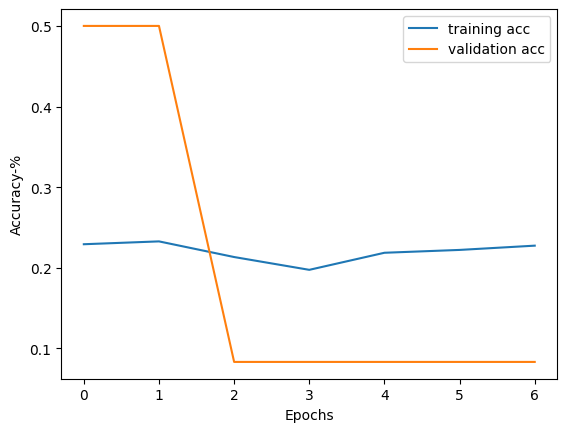

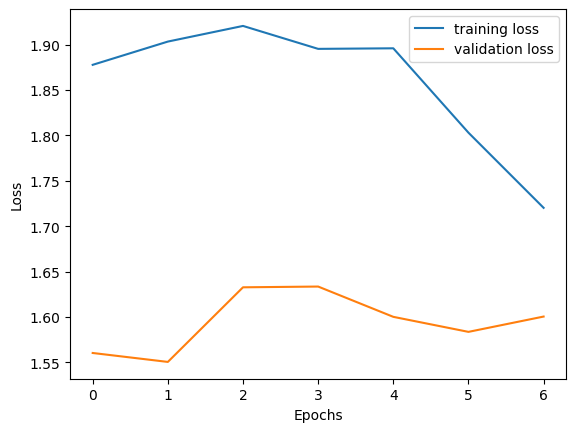

In [38]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy-%')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plot_learning_curve(history)

In [39]:
#METRICS
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1. Predict the classes and probabilities for the test dataset
test_pred_prob = model_resnet50.predict(test_ds)
test_pred = np.argmax(test_pred_prob, axis=1)
test_true = test_ds.labels

# Determine the number of classes in the test dataset
n_classes = len(np.unique(test_true))

# 2. Compute the metrics for the test dataset

# Test metrics
test_precision = precision_score(test_true, test_pred, average='weighted', zero_division=1)
test_recall = recall_score(test_true, test_pred, average='weighted')
test_f1 = f1_score(test_true, test_pred, average='weighted')
test_conf_matrix = confusion_matrix(test_true, test_pred, labels=list(range(n_classes)))
test_true_onehot = np.eye(n_classes)[test_true]
test_roc_auc = roc_auc_score(test_true_onehot, test_pred_prob, multi_class='ovr')

# Create a dataframe to display the results for the test set
test_metrics_df = pd.DataFrame({
    'Test': [test_precision, test_recall, test_f1, test_roc_auc]
}, index=['Precision', 'Recall', 'F1 Score', 'AUC'])

print("Test Metrics DataFrame:")
print(test_metrics_df)

print("\nTest Confusion Matrix:")
print(test_conf_matrix)


2/2 [==============================] - 20s 6s/step
Test Metrics DataFrame:
               Test
Precision  0.751019
Recall     0.468085
F1 Score   0.298489
AUC        0.591056

Test Confusion Matrix:
[[22  0  0  0  0]
 [11  0  0  0  0]
 [ 5  0  0  0  0]
 [ 7  0  0  0  0]
 [ 2  0  0  0  0]]


In [40]:
# Assuming test_conf_matrix is already computed as shown in your code
n_classes = len(np.unique(test_true))  # Number of classes

# Initialize arrays to store TP, FP, FN, TN for each class
TP = np.zeros(n_classes)
FP = np.zeros(n_classes)
FN = np.zeros(n_classes)
TN = np.zeros(n_classes)

# Calculate TP, FP, FN, TN for each class
for i in range(n_classes):
    TP[i] = test_conf_matrix[i, i]
    FP[i] = test_conf_matrix[:, i].sum() - TP[i]
    FN[i] = test_conf_matrix[i, :].sum() - TP[i]
    TN[i] = test_conf_matrix.sum() - (FP[i] + FN[i] + TP[i])

print("Confusion Matrix Metrics by Class:")
TP_list = TP.tolist()
TN_list = TN.tolist()
FP_list = FP.tolist()
FN_list = FN.tolist()

metrics_by_class = list(zip(TP_list, TN_list, FP_list, FN_list))

# Print the transposed lists
for i, class_metrics in enumerate(metrics_by_class):
    print(f"Class {i}: {class_metrics}")

Confusion Matrix Metrics by Class:
Class 0: (22.0, 0.0, 25.0, 0.0)
Class 1: (0.0, 36.0, 0.0, 11.0)
Class 2: (0.0, 42.0, 0.0, 5.0)
Class 3: (0.0, 40.0, 0.0, 7.0)
Class 4: (0.0, 45.0, 0.0, 2.0)


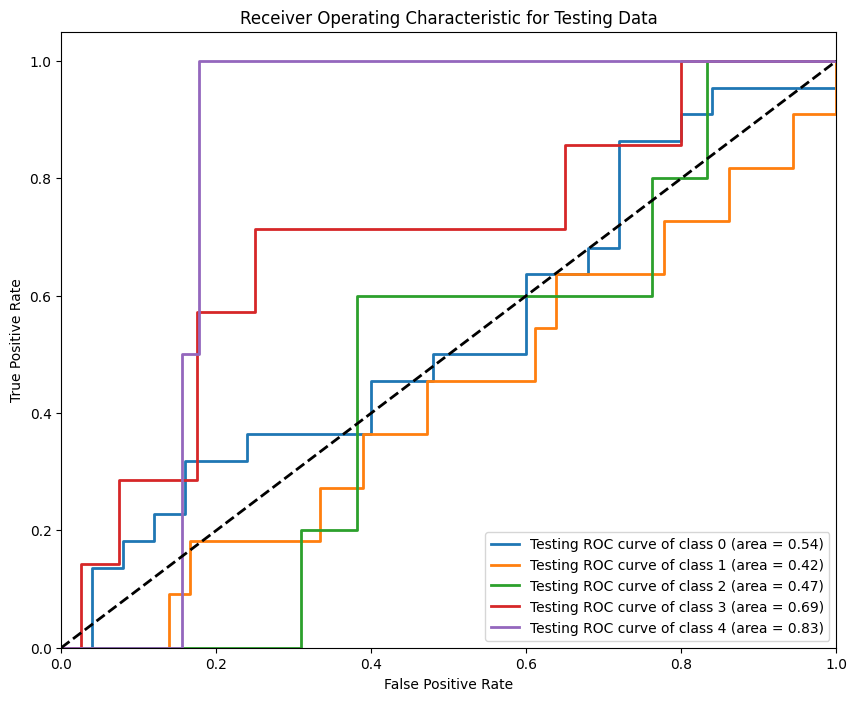

In [41]:
#Matrix Visualization
# Testing AUC curve
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(test_true_onehot[:, i], test_pred_prob[:, i])
    plt.plot(fpr, tpr, lw=2, label=f'Testing ROC curve of class {i} (area = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Testing Data')
plt.legend(loc="lower right")
plt.show()

In [42]:
#TEST CASES INSERTION

# Assuming that the TP_list, TN_list, FP_list, and FN_list have been calculated
TP_list = TP.tolist()
TN_list = TN.tolist()
FP_list = FP.tolist()
FN_list = FN.tolist()
metrics_flat = [item for sublist in zip(TP_list, TN_list, FP_list, FN_list) for item in sublist]

# Data to append
data_to_append = [
    #ACCCURACY AND LOSS
    train_result[0],  # Training loss [B]
    train_result[1],  # Training accuracy [C]
    val_result[0],    # Validation loss [D]
    val_result[1],     # Validation accuracy [E]
    test_result[0],    # Testing loss [F]
    test_result[1],     # Testing accuracy [G]
    test_precision,
    test_recall,
    test_f1,
    test_roc_auc
]

#Insertion
# Find the first empty row in column B
col_values = sheet.col_values(2)  # Column number for 'B' is 2
first_empty_row = len(col_values) + 1

# Calculate the range to update
start_cell = rowcol_to_a1(first_empty_row, 2)  # Start at column B
end_cell = rowcol_to_a1(first_empty_row, 1 + len(data_to_append))  # Adjust the end column based on data length
cell_range = f"{start_cell}:{end_cell}"

# Update the entire row at once
sheet.update(cell_range, [data_to_append])

#FOR CONFUSION MATRIX INSERTION
# Loop through the metrics_flat and update each cell
for index, value in enumerate(metrics_flat):
    # Calculate row and column offset
    row_offset = (index // 4) + first_empty_row
    col_offset = (index % 4) + 12

    # Convert to A1 notation and update the cell
    cell_range = rowcol_to_a1(first_empty_row, 12) + ':' + rowcol_to_a1(first_empty_row, 12 + len(metrics_flat) - 1)
    sheet.update(cell_range, [metrics_flat])

## Improved ResNet50 Model

In [43]:
import tensorflow as tf

tf.keras.backend.clear_session()

# Assuming height and width are defined elsewhere in your code
input_shape = (height, width, 3)

# Using ResNet50 as the base model
# Make the last block of the ResNet trainable
for layer in base_model_resnet50.layers[:-10]:
    layer.trainable = False

model_resnet50 = tf.keras.Sequential()
model_resnet50.add(base_model_resnet50)

#Added layers start here
model_resnet50.add(tf.keras.layers.GlobalAveragePooling2D())
model_resnet50.add(tf.keras.layers.BatchNormalization())
model_resnet50.add(tf.keras.layers.Dense(1024, activation='relu'))
model_resnet50.add(tf.keras.layers.Dropout(0.5))

model_resnet50.add(tf.keras.layers.Dense(5, activation='softmax')) # Adjusted for 5 classes

model_resnet50.compile(loss='categorical_crossentropy',
                       optimizer=tf.keras.optimizers.Adam(0.0001),  # Adam optimizer
                       metrics=['accuracy'])  # Using 'accuracy' instead of 'acc' for clarity

model_resnet50.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 13, 32, 2048)      23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 5)                 5

In [44]:
# Adjusting to monitor validation accuracy
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/My Drive/THESIS 2/Thesis Internal/Code/model/resnet50_tuned.h5', monitor='val_loss', verbose=1, mode='min', save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", restore_best_weights=True, patience=5)
time_callback = TimingCallback()
callbacks_list = [checkpoint, early, time_callback]

history = model_resnet50.fit(
        train_ds,
        validation_data=val_ds,
        epochs=50,
        shuffle=True,
        verbose=True,
        callbacks=callbacks_list,
        class_weight=class_weight_dict  # Pass class weights here
)


Epoch 1/50
5/5 [==============================] - ETA: 0s - loss: 1.5985 - accuracy: 0.1769
Epoch 1: val_loss improved from inf to 1.43140, saving model to /content/drive/My Drive/THESIS 2/Thesis Internal/Code/model/resnet50_tuned.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1: 65.35 seconds
5/5 [==============================] - 65s 12s/step - loss: 1.5985 - accuracy: 0.1769 - val_loss: 1.4314 - val_accuracy: 0.5000
Epoch 2/50
5/5 [==============================] - ETA: 0s - loss: 1.4615 - accuracy: 0.3692
Epoch 2: val_loss did not improve from 1.43140
Epoch 2: 59.47 seconds
5/5 [==============================] - 59s 11s/step - loss: 1.4615 - accuracy: 0.3692 - val_loss: 1.4624 - val_accuracy: 0.5000
Epoch 3/50
5/5 [==============================] - ETA: 0s - loss: 1.4038 - accuracy: 0.4077
Epoch 3: val_loss did not improve from 1.43140
Epoch 3: 59.22 seconds
5/5 [==============================] - 59s 11s/step - loss: 1.4038 - accuracy: 0.4077 - val_loss: 1.5549 - val_accuracy: 0.5000
Epoch 4/50
5/5 [==============================] - ETA: 0s - loss: 1.3525 - accuracy: 0.4692
Epoch 4: val_loss did not improve from 1.43140
Epoch 4: 59.15 seconds
5/5 [==============================] - 59s 11s/step - loss: 1.3525 - accuracy: 0.4692 - val_loss: 1.6218 - 

## Evaluation of *Tuned Model*

In [45]:
train_result = model_resnet50.evaluate(train_ds)
val_result = model_resnet50.evaluate(val_ds)
test_result = model_resnet50.evaluate(test_ds)

no_augmented_df = pd.DataFrame(zip(train_result,val_result,test_result),columns=['Train','Val','Test'],index=['Loss','Acc'])
no_augmented_df

2/2 [==============================] - 20s 6s/step - loss: 1.6762 - accuracy: 0.4681


,Train,Val,Test
Loss,1.596173,1.431396,1.676239
Acc,0.446154,0.500000,0.468085


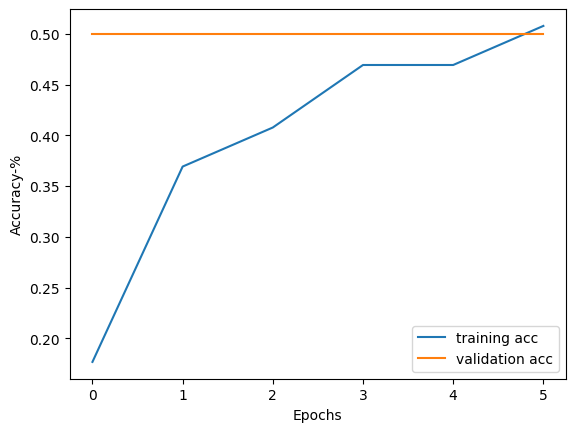

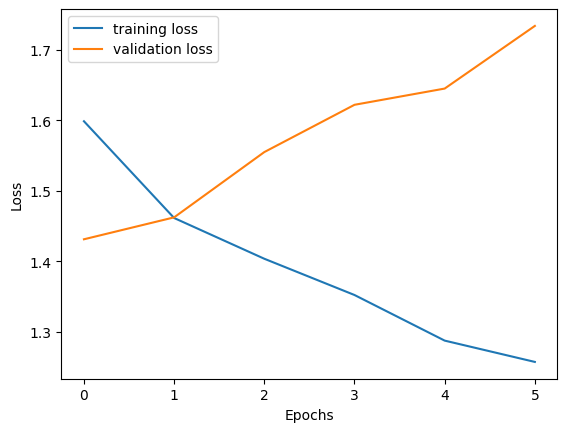

In [46]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy-%')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plot_learning_curve(history)

In [47]:
#METRICS
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1. Predict the classes and probabilities for the test dataset
test_pred_prob = model_resnet50.predict(test_ds)
test_pred = np.argmax(test_pred_prob, axis=1)
test_true = test_ds.labels

# Determine the number of classes in the test dataset
n_classes = len(np.unique(test_true))

# 2. Compute the metrics for the test dataset

# Test metrics
test_precision = precision_score(test_true, test_pred, average='weighted', zero_division=1)
test_recall = recall_score(test_true, test_pred, average='weighted')
test_f1 = f1_score(test_true, test_pred, average='weighted')
test_conf_matrix = confusion_matrix(test_true, test_pred, labels=list(range(n_classes)))
test_true_onehot = np.eye(n_classes)[test_true]
test_roc_auc = roc_auc_score(test_true_onehot, test_pred_prob, multi_class='ovr')

# Create a dataframe to display the results for the test set
test_metrics_df = pd.DataFrame({
    'Test': [test_precision, test_recall, test_f1, test_roc_auc]
}, index=['Precision', 'Recall', 'F1 Score', 'AUC'])

print("Test Metrics DataFrame:")
print(test_metrics_df)

print("\nTest Confusion Matrix:")
print(test_conf_matrix)


2/2 [==============================] - 21s 6s/step
Test Metrics DataFrame:
               Test
Precision  0.751019
Recall     0.468085
F1 Score   0.298489
AUC        0.597251

Test Confusion Matrix:
[[22  0  0  0  0]
 [11  0  0  0  0]
 [ 5  0  0  0  0]
 [ 7  0  0  0  0]
 [ 2  0  0  0  0]]


In [48]:
# Assuming test_conf_matrix is already computed as shown in your code
n_classes = len(np.unique(test_true))  # Number of classes

# Initialize arrays to store TP, FP, FN, TN for each class
TP = np.zeros(n_classes)
FP = np.zeros(n_classes)
FN = np.zeros(n_classes)
TN = np.zeros(n_classes)

# Calculate TP, FP, FN, TN for each class
for i in range(n_classes):
    TP[i] = test_conf_matrix[i, i]
    FP[i] = test_conf_matrix[:, i].sum() - TP[i]
    FN[i] = test_conf_matrix[i, :].sum() - TP[i]
    TN[i] = test_conf_matrix.sum() - (FP[i] + FN[i] + TP[i])

print("Confusion Matrix Metrics by Class:")
TP_list = TP.tolist()
TN_list = TN.tolist()
FP_list = FP.tolist()
FN_list = FN.tolist()

metrics_by_class = list(zip(TP_list, TN_list, FP_list, FN_list))

# Print the transposed lists
for i, class_metrics in enumerate(metrics_by_class):
    print(f"Class {i}: {class_metrics}")

Confusion Matrix Metrics by Class:
Class 0: (22.0, 0.0, 25.0, 0.0)
Class 1: (0.0, 36.0, 0.0, 11.0)
Class 2: (0.0, 42.0, 0.0, 5.0)
Class 3: (0.0, 40.0, 0.0, 7.0)
Class 4: (0.0, 45.0, 0.0, 2.0)


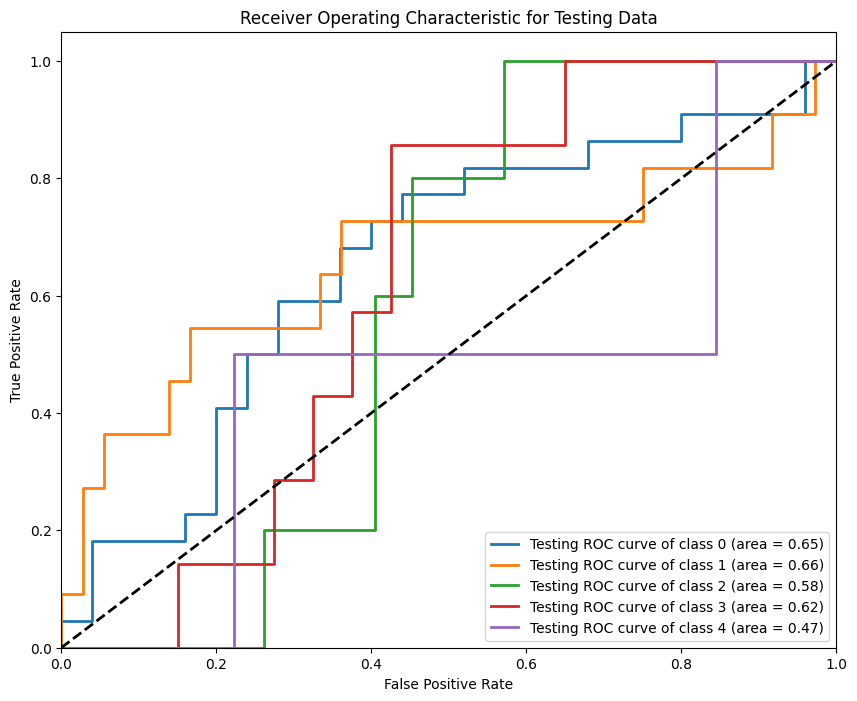

In [49]:
#Matrix Visualization
# Testing AUC curve
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(test_true_onehot[:, i], test_pred_prob[:, i])
    plt.plot(fpr, tpr, lw=2, label=f'Testing ROC curve of class {i} (area = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Testing Data')
plt.legend(loc="lower right")
plt.show()

In [50]:
#TEST CASES INSERTION

# Assuming that the TP_list, TN_list, FP_list, and FN_list have been calculated
TP_list = TP.tolist()
TN_list = TN.tolist()
FP_list = FP.tolist()
FN_list = FN.tolist()
metrics_flat = [item for sublist in zip(TP_list, TN_list, FP_list, FN_list) for item in sublist]

# Data to append
data_to_append = [
    #ACCCURACY AND LOSS
    train_result[0],  # Training loss [B]
    train_result[1],  # Training accuracy [C]
    val_result[0],    # Validation loss [D]
    val_result[1],     # Validation accuracy [E]
    test_result[0],    # Testing loss [F]
    test_result[1],     # Testing accuracy [G]
    test_precision,
    test_recall,
    test_f1,
    test_roc_auc
]

#Insertion
# Find the first empty row in column B
col_values = sheet.col_values(2)  # Column number for 'B' is 2
first_empty_row = len(col_values) + 1

# Calculate the range to update
start_cell = rowcol_to_a1(first_empty_row, 2)  # Start at column B
end_cell = rowcol_to_a1(first_empty_row, 1 + len(data_to_append))  # Adjust the end column based on data length
cell_range = f"{start_cell}:{end_cell}"

# Update the entire row at once
sheet.update(cell_range, [data_to_append])

#FOR CONFUSION MATRIX INSERTION
# Loop through the metrics_flat and update each cell
for index, value in enumerate(metrics_flat):
    # Calculate row and column offset
    row_offset = (index // 4) + first_empty_row
    col_offset = (index % 4) + 12

    # Convert to A1 notation and update the cell
    cell_range = rowcol_to_a1(first_empty_row, 12) + ':' + rowcol_to_a1(first_empty_row, 12 + len(metrics_flat) - 1)
    sheet.update(cell_range, [metrics_flat])

In [51]:
# Add a ReduceLROnPlateau callback to reduce the learning rate when the validation loss plateaus
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001, #to change reduce_lr
    verbose=1
)
callbacks_list = [checkpoint, early, time_callback, reduce_lr]

history = model_resnet50.fit(
        aug_train_ds,
        validation_data=val_ds,
        epochs=50,
        shuffle=True,
        verbose=True,
        callbacks=callbacks_list,
        class_weight=class_weight_dict  # Pass class weights here
        )


Epoch 1/50
18/18 [==============================] - ETA: 0s - loss: 1.6093 - accuracy: 0.2681 
Epoch 1: val_loss improved from 1.43140 to 1.42704, saving model to /content/drive/My Drive/THESIS 2/Thesis Internal/Code/model/resnet50_tuned.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1: 244.25 seconds
18/18 [==============================] - 244s 13s/step - loss: 1.6093 - accuracy: 0.2681 - val_loss: 1.4270 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 2/50
18/18 [==============================] - ETA: 0s - loss: 1.4865 - accuracy: 0.3739 
Epoch 2: val_loss improved from 1.42704 to 1.33530, saving model to /content/drive/My Drive/THESIS 2/Thesis Internal/Code/model/resnet50_tuned.h5
Epoch 2: 242.34 seconds
18/18 [==============================] - 242s 13s/step - loss: 1.4865 - accuracy: 0.3739 - val_loss: 1.3353 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 3/50
18/18 [==============================] - ETA: 0s - loss: 1.4465 - accuracy: 0.3492 
Epoch 3: val_loss did not improve from 1.33530
Epoch 3: 239.66 seconds
18/18 [==============================] - 240s 13s/step - loss: 1.4465 - accuracy: 0.3492 - val_loss: 1.3382 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 4/50
18/18 [==============================] - ETA: 0s - loss: 1.3985 - accuracy: 0.4268 
Epoch 

## Evaluation of *Tuned Model* with **Augmentation**

In [52]:
train_result = model_resnet50.evaluate(train_ds)
val_result = model_resnet50.evaluate(val_ds)
test_result = model_resnet50.evaluate(test_ds)

augmented_df = pd.DataFrame(zip(train_result,val_result,test_result),columns=['Train','Val','Test'],index=['Loss','Acc'])
augmented_df

2/2 [==============================] - 20s 6s/step - loss: 1.4888 - accuracy: 0.4681


,Train,Val,Test
Loss,1.456867,1.335305,1.488804
Acc,0.446154,0.500000,0.468085


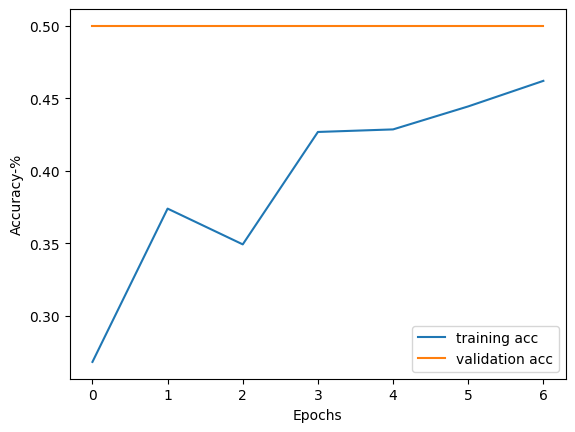

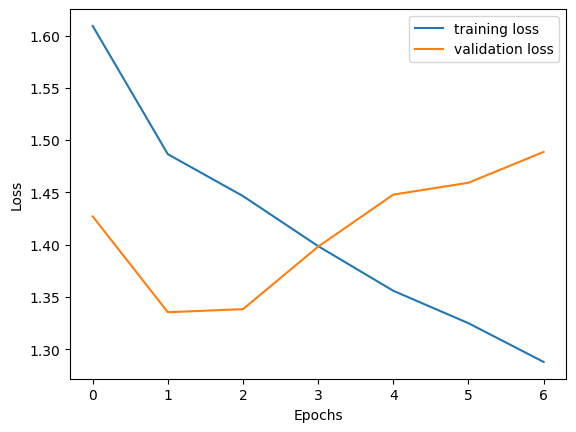

In [53]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy-%')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plot_learning_curve(history)

In [55]:
#METRICS
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1. Predict the classes and probabilities for the test dataset
test_pred_prob = model_resnet50.predict(test_ds)
test_pred = np.argmax(test_pred_prob, axis=1)
test_true = test_ds.labels

# Determine the number of classes in the test dataset
n_classes = len(np.unique(test_true))

# 2. Compute the metrics for the test dataset

# Test metrics
test_precision = precision_score(test_true, test_pred, average='weighted', zero_division=1)
test_recall = recall_score(test_true, test_pred, average='weighted')
test_f1 = f1_score(test_true, test_pred, average='weighted')
test_conf_matrix = confusion_matrix(test_true, test_pred, labels=list(range(n_classes)))
test_true_onehot = np.eye(n_classes)[test_true]
test_roc_auc = roc_auc_score(test_true_onehot, test_pred_prob, multi_class='ovr')

# Create a dataframe to display the results for the test set
test_metrics_df = pd.DataFrame({
    'Test': [test_precision, test_recall, test_f1, test_roc_auc]
}, index=['Precision', 'Recall', 'F1 Score', 'AUC'])

print("Test Metrics DataFrame:")
print(test_metrics_df)

print("\nTest Confusion Matrix:")
print(test_conf_matrix)


2/2 [==============================] - 21s 6s/step
Test Metrics DataFrame:
               Test
Precision  0.751019
Recall     0.468085
F1 Score   0.298489
AUC        0.573863

Test Confusion Matrix:
[[22  0  0  0  0]
 [11  0  0  0  0]
 [ 5  0  0  0  0]
 [ 7  0  0  0  0]
 [ 2  0  0  0  0]]


In [56]:
# Assuming test_conf_matrix is already computed as shown in your code
n_classes = len(np.unique(test_true))  # Number of classes

# Initialize arrays to store TP, FP, FN, TN for each class
TP = np.zeros(n_classes)
FP = np.zeros(n_classes)
FN = np.zeros(n_classes)
TN = np.zeros(n_classes)

# Calculate TP, FP, FN, TN for each class
for i in range(n_classes):
    TP[i] = test_conf_matrix[i, i]
    FP[i] = test_conf_matrix[:, i].sum() - TP[i]
    FN[i] = test_conf_matrix[i, :].sum() - TP[i]
    TN[i] = test_conf_matrix.sum() - (FP[i] + FN[i] + TP[i])

print("Confusion Matrix Metrics by Class:")
TP_list = TP.tolist()
TN_list = TN.tolist()
FP_list = FP.tolist()
FN_list = FN.tolist()

metrics_by_class = list(zip(TP_list, TN_list, FP_list, FN_list))

# Print the transposed lists
for i, class_metrics in enumerate(metrics_by_class):
    print(f"Class {i}: {class_metrics}")

Confusion Matrix Metrics by Class:
Class 0: (22.0, 0.0, 25.0, 0.0)
Class 1: (0.0, 36.0, 0.0, 11.0)
Class 2: (0.0, 42.0, 0.0, 5.0)
Class 3: (0.0, 40.0, 0.0, 7.0)
Class 4: (0.0, 45.0, 0.0, 2.0)


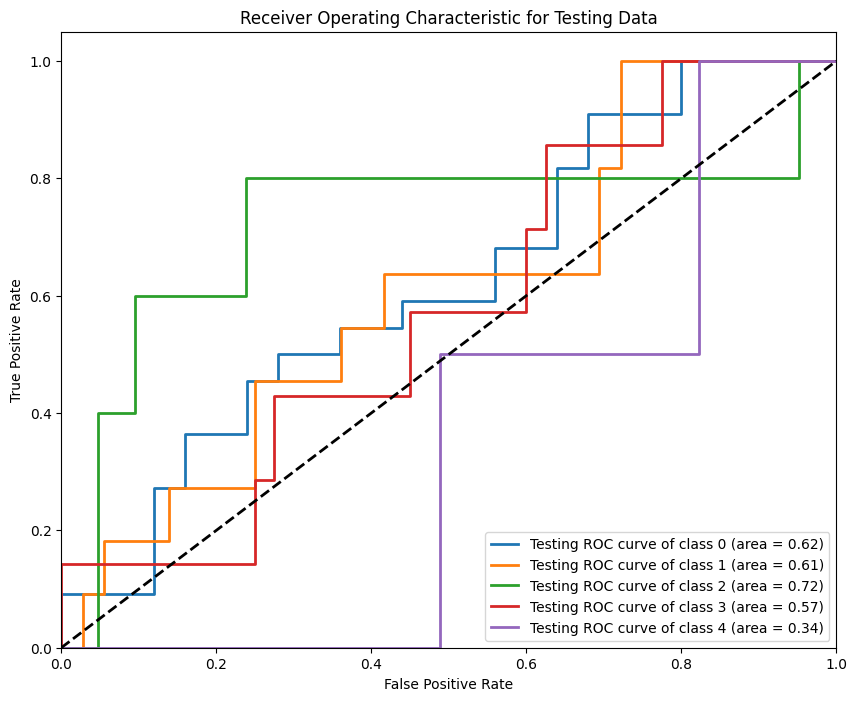

In [57]:
#Matrix Visualization
# Training AUC curve
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(test_true_onehot[:, i], test_pred_prob[:, i])
    plt.plot(fpr, tpr, lw=2, label=f'Testing ROC curve of class {i} (area = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Testing Data')
plt.legend(loc="lower right")
plt.show()

In [58]:
#TEST CASES INSERTION

# Assuming that the TP_list, TN_list, FP_list, and FN_list have been calculated
TP_list = TP.tolist()
TN_list = TN.tolist()
FP_list = FP.tolist()
FN_list = FN.tolist()
metrics_flat = [item for sublist in zip(TP_list, TN_list, FP_list, FN_list) for item in sublist]

# Data to append
data_to_append = [
    #ACCCURACY AND LOSS
    train_result[0],  # Training loss [B]
    train_result[1],  # Training accuracy [C]
    val_result[0],    # Validation loss [D]
    val_result[1],     # Validation accuracy [E]
    test_result[0],    # Testing loss [F]
    test_result[1],     # Testing accuracy [G]
    test_precision,
    test_recall,
    test_f1,
    test_roc_auc
]

#Insertion
# Find the first empty row in column B
col_values = sheet.col_values(2)  # Column number for 'B' is 2
first_empty_row = len(col_values) + 1

# Calculate the range to update
start_cell = rowcol_to_a1(first_empty_row, 2)  # Start at column B
end_cell = rowcol_to_a1(first_empty_row, 1 + len(data_to_append))  # Adjust the end column based on data length
cell_range = f"{start_cell}:{end_cell}"

# Update the entire row at once
sheet.update(cell_range, [data_to_append])

#FOR CONFUSION MATRIX INSERTION
# Loop through the metrics_flat and update each cell
for index, value in enumerate(metrics_flat):
    # Calculate row and column offset
    row_offset = (index // 4) + first_empty_row
    col_offset = (index % 4) + 12

    # Convert to A1 notation and update the cell
    cell_range = rowcol_to_a1(first_empty_row, 12) + ':' + rowcol_to_a1(first_empty_row, 12 + len(metrics_flat) - 1)
    sheet.update(cell_range, [metrics_flat])

## Metrics of Final Model

In [ ]:
# # plot learning curve
# def plot_learning_curve(history):
#     acc = history.history['acc']
#     val_acc = history.history['val_acc']
#     loss = history.history['loss']
#     val_loss = history.history['val_loss']
#     epochs = range(len(acc))

#     plt.plot(epochs, acc, label='training acc')
#     plt.plot(epochs, val_acc, label='validation acc')
#     plt.xlabel('Epochs')
#     plt.ylabel('Accuracy-%')
#     plt.legend()
#     plt.figure()

#     plt.plot(epochs, loss, label='training loss')
#     plt.plot(epochs, val_loss, label='validation loss')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend()

# plot_learning_curve(history)

In [ ]:
# from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
# import matplotlib.pyplot as plt

# # 1. Predict the classes and probabilities for the training and validation datasets
# train_pred_prob = model_inceptionv3.predict(train_ds)
# train_pred = np.argmax(train_pred_prob, axis=1)
# train_true = train_ds.labels

# val_pred_prob = model_inceptionv3.predict(val_ds)
# val_pred = np.argmax(val_pred_prob, axis=1)
# val_true = val_ds.labels

# n_classes = len(np.unique(train_true))

# # 2. Compute the metrics for both training and validation datasets

# # Training metrics
# train_precision = precision_score(train_true, train_pred, average='weighted', zero_division=1)
# # train_precision = precision_score(train_true, train_pred, average='weighted')
# train_recall = recall_score(train_true, train_pred, average='weighted')
# train_f1 = f1_score(train_true, train_pred, average='weighted')
# train_conf_matrix = confusion_matrix(train_true, train_pred)
# train_true_onehot = np.eye(n_classes)[train_true]
# train_roc_auc = roc_auc_score(train_true_onehot, train_pred_prob, multi_class='ovr')

# # Validation metrics
# val_precision = precision_score(val_true, val_pred, average='weighted', zero_division=1)
# # val_precision = precision_score(val_true, val_pred, average='weighted')
# val_recall = recall_score(val_true, val_pred, average='weighted')
# val_f1 = f1_score(val_true, val_pred, average='weighted')
# val_conf_matrix = confusion_matrix(val_true, val_pred)
# val_true_onehot = np.eye(n_classes)[val_true]
# val_roc_auc = roc_auc_score(val_true_onehot, val_pred_prob, multi_class='ovr')

# # Create a dataframe to display the results
# metrics_df = pd.DataFrame({
#     'Train': [train_precision, train_recall, train_f1, train_roc_auc],
#     'Val': [val_precision, val_recall, val_f1, val_roc_auc]
# }, index=['Precision', 'Recall', 'F1 Score', 'AUC'])

# print("Metrics DataFrame:")
# print(metrics_df)

# print("\nTraining Confusion Matrix:")
# print(train_conf_matrix)

# print("\nValidation Confusion Matrix:")
# print(val_conf_matrix)


In [ ]:
# # Training AUC curve
# plt.figure(figsize=(10, 8))
# for i in range(n_classes):
#     fpr, tpr, _ = roc_curve(train_true_onehot[:, i], train_pred_prob[:, i])
#     plt.plot(fpr, tpr, lw=2, label=f'Training ROC curve of class {i} (area = {auc(fpr, tpr):.2f})')
# plt.plot([0, 1], [0, 1], 'k--', lw=2)
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic for Training Data')
# plt.legend(loc="lower right")
# plt.show()

# # Validation AUC curve
# plt.figure(figsize=(10, 8))
# for i in range(n_classes):
#     fpr, tpr, _ = roc_curve(val_true_onehot[:, i], val_pred_prob[:, i])
#     plt.plot(fpr, tpr, lw=2, linestyle='--', label=f'Validation ROC curve of class {i} (area = {auc(fpr, tpr):.2f})')
# plt.plot([0, 1], [0, 1], 'k--', lw=2)
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic for Validation Data')
# plt.legend(loc="lower right")
# plt.show()
